MODIS-AERONET AOD VALIDATION WORKFLOW

1. Processing AERONET data...
AERONET data processed: 9803 records saved to D:\DATA\COMPLETED\NIGERIA\NEW OUTPUTS\aeronet_extracted.csv

2. Extracting MODIS data...
Processing 852 MODIS files...
  File 1/852: 21632 valid pixels
  File 2/852: 5386 valid pixels
  File 3/852: 19789 valid pixels
  File 4/852: 19391 valid pixels
  File 5/852: 9587 valid pixels
  File 6/852: 23619 valid pixels
  File 7/852: 7991 valid pixels
  File 8/852: 16346 valid pixels
  File 9/852: 20655 valid pixels
  File 10/852: 8164 valid pixels
  File 11/852: 19415 valid pixels
  File 12/852: 18418 valid pixels
  File 13/852: 7832 valid pixels
  File 14/852: 21665 valid pixels
  File 15/852: 7893 valid pixels
  File 16/852: 13119 valid pixels
  File 17/852: 20463 valid pixels
  File 18/852: 8765 valid pixels
  File 19/852: 19061 valid pixels
  File 20/852: 17709 valid pixels
  File 21/852: 14974 valid pixels
  File 22/852: 17140 valid pixels
  File 23/852: 4615 valid pixels
 

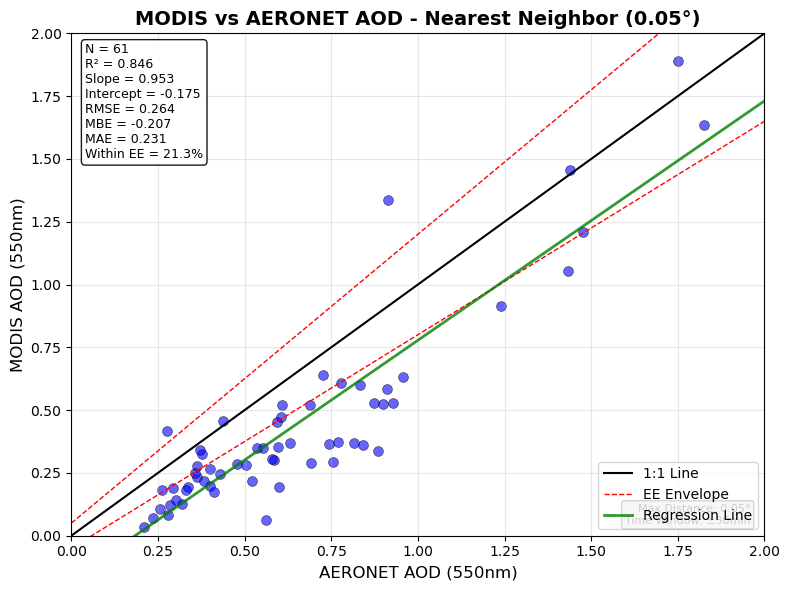

Collocated data saved: D:\DATA\COMPLETED\NIGERIA\NEW OUTPUTS\collocated_data_nearest_{'max_distance': 0.1}.csv

4.2. Testing 3×3 Grid Average...
----------------------------------------
AERONET station location: 8.4841°N, 4.6745°E
Spatial matching method: grid
Temporal window: ±30 minutes
Processing 338 MODIS overpasses...
Successfully matched: 43/338 MODIS overpasses


OSError: [Errno 22] Invalid argument: "D:\\DATA\\COMPLETED\\NIGERIA\\NEW OUTPUTS\\validation_plot_grid_{'grid_size': 3, 'pixel_size': 0.05}.png"

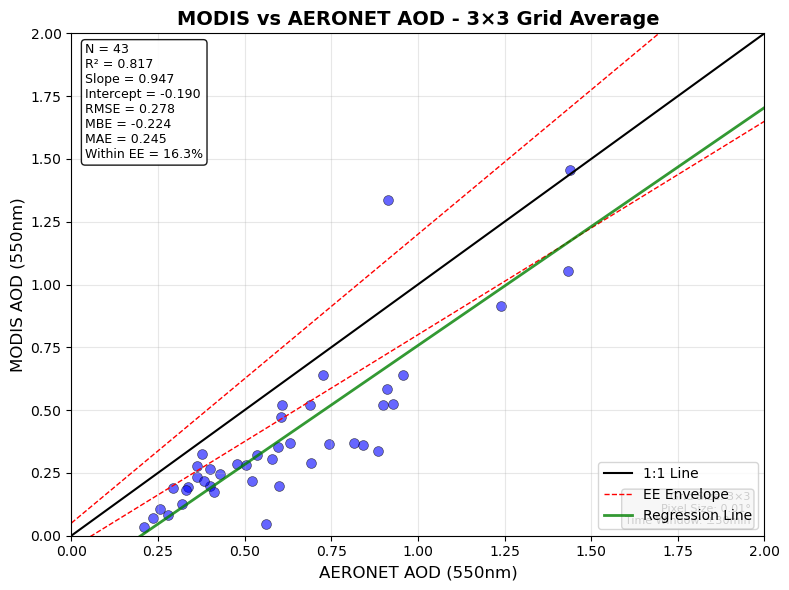

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
from pyhdf.SD import SD, SDC
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist


def process_aeronet_data(file_path, output_path):
    """
    Process AERONET data and extract required fields
    
    Args:
        file_path (str): Path to input AERONET CSV file
        output_path (str): Path to save processed data
    """
    df = pd.read_csv(file_path, skiprows=6)
    df.columns = df.columns.str.strip()

    # Clean time format and create datetime
    df['Time(hh:mm:ss)'] = df['Time(hh:mm:ss)'].str[:-3]
    df['dateTime'] = pd.to_datetime(df['Date(dd:mm:yyyy)'] + ' ' + df['Time(hh:mm:ss)'],
                                    format='mixed')

    # Format datetime for consistency
    df['dateTime'] = df['dateTime'].dt.strftime('%m/%d/%Y %I:%M:%S %p')

    # Calculate AOD at 550nm using Angstrom exponent
    df['AOD_550nm'] = df['AOD_500nm'] * (550 / 500) ** (-df['500-870_Angstrom_Exponent'])

    # Create output dataframe with required fields
    output_df = pd.DataFrame({
        'dateTime': df['dateTime'],
        'Latitude': df['Site_Latitude(Degrees)'],
        'Longitude': df['Site_Longitude(Degrees)'],
        'AOD_550nm': df['AOD_550nm']
    })

    output_df.to_csv(output_path, index=False)
    print(f"AERONET data processed: {len(output_df)} records saved to {output_path}")
    

def parse_datetime_from_filename(filename):
    """
    Parse datetime from MODIS HDF filename
    
    Args:
        filename (str): MODIS HDF filename
        
    Returns:
        datetime: Parsed datetime object
    """
    parts = filename.split('.')
    year = int(parts[1][1:5])
    doy = int(parts[1][5:8])  # Day of year
    hour = int(parts[2][:2])
    minute = int(parts[2][2:4])
    return datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute)


def extract_modis_data(file_list_path, hdf_dir, output_path):
    """
    Extract MODIS AOD data from HDF files
    
    Args:
        file_list_path (str): Path to file containing list of HDF files
        hdf_dir (str): Directory containing HDF files
        output_path (str): Path to save extracted data
    """
    data_fields = [
        "AOD_550_Dark_Target_Deep_Blue_Combined",
        "AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag"
    ]
    data_list = []

    # Read file list
    with open(file_list_path, 'r', encoding="utf-8") as f:
        files = f.readlines()

    print(f"Processing {len(files)} MODIS files...")

    for idx, file_name in enumerate(files):
        file_name = file_name.strip()
        full_path = os.path.join(hdf_dir, file_name)

        try:
            # Open HDF file
            hdf = SD(full_path, SDC.READ)
            dt = parse_datetime_from_filename(file_name)
            
            # Read latitude and longitude (2D arrays)
            lat = hdf.select("Latitude")[:]
            lon = hdf.select("Longitude")[:]

            # Get array dimensions
            ny, nx = lat.shape
            
            record_data = []
            
            # Read AOD and QA data
            for field in data_fields:
                sds = hdf.select(field)
                attrs = sds.attributes()
                data = sds.get().astype(np.float32)
                
                # Apply scale factor if available
                data = data * attrs.get("scale_factor", 1)
                
                # Set fill values to NaN
                data[data == attrs.get("_FillValue", -9999)] = np.nan
                
                if field == "AOD_550_Dark_Target_Deep_Blue_Combined":
                    aod_data = data
                elif field == "AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag":
                    qa_data = data

            # Filter pixels with QA >= 3 (good quality)
            valid_mask = (qa_data >= 3) & (~np.isnan(aod_data))
            
            # Convert 2D data to list of records
            for i in range(ny):
                for j in range(nx):
                    if valid_mask[i, j]:
                        record_data.append({
                            "datetime": dt,
                            "latitude": lat[i, j],
                            "longitude": lon[i, j],
                            "AOD_550": aod_data[i, j],
                            "QA_flag": qa_data[i, j]
                        })
            
            if record_data:
                temp_df = pd.DataFrame(record_data)
                data_list.append(temp_df)
                print(f"  File {idx+1}/{len(files)}: {len(record_data)} valid pixels")
            else:
                print(f"  File {idx+1}/{len(files)}: No valid pixels")

            hdf.end()

        except Exception as e:
            print(f"Error reading {full_path}: {e}")

    # Combine all data
    if data_list:
        result_df = pd.concat(data_list, ignore_index=True)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        result_df.to_csv(output_path, index=False)
        print(f"MODIS data extracted: {len(result_df)} total valid pixels saved to {output_path}")
    else:
        print("No valid MODIS data found")


def spatial_matching_nearest_neighbor(aeronet_lat, aeronet_lon, modis_df, max_distance=0.05):
    """
    Nearest neighbor spatial matching method
    
    Args:
        aeronet_lat (float): AERONET station latitude
        aeronet_lon (float): AERONET station longitude  
        modis_df (DataFrame): MODIS data for the day
        max_distance (float): Maximum distance threshold in degrees (default 0.05°)
        
    Returns:
        float or None: MODIS AOD value of nearest pixel, or None if no pixel within threshold
    """
    if len(modis_df) == 0:
        return None
    
    # Calculate distances from all MODIS pixels to AERONET station
    modis_coords = modis_df[['latitude', 'longitude']].values
    aeronet_coord = np.array([[aeronet_lat, aeronet_lon]])
    
    # Use Euclidean distance (approximation for small areas)
    distances = cdist(aeronet_coord, modis_coords, metric='euclidean').flatten()
    
    # Find the nearest pixel
    min_idx = np.argmin(distances)
    min_distance = distances[min_idx]
    
    if min_distance <= max_distance:
        return modis_df.iloc[min_idx]['AOD_550']
    else:
        return None


def spatial_matching_grid_average(aeronet_lat, aeronet_lon, modis_df, grid_size=3, pixel_size=0.01):
    """
    Grid averaging spatial matching method
    
    Args:
        aeronet_lat (float): AERONET station latitude
        aeronet_lon (float): AERONET station longitude
        modis_df (DataFrame): MODIS data for the day
        grid_size (int): Grid size (3 for 3x3, 5 for 5x5)
        pixel_size (float): MODIS pixel size in degrees (default 0.01° ≈ 1km)
        
    Returns:
        float or None: Average AOD of pixels within grid, or None if no pixels found
    """
    if len(modis_df) == 0:
        return None
    
    # Calculate grid extent
    half_grid = (grid_size - 1) / 2
    grid_extent = half_grid * pixel_size
    
    # Filter MODIS pixels within grid bounds
    lat_mask = (modis_df['latitude'] >= aeronet_lat - grid_extent) & \
               (modis_df['latitude'] <= aeronet_lat + grid_extent)
    lon_mask = (modis_df['longitude'] >= aeronet_lon - grid_extent) & \
               (modis_df['longitude'] <= aeronet_lon + grid_extent)
    
    grid_pixels = modis_df[lat_mask & lon_mask]
    
    if len(grid_pixels) > 0:
        return grid_pixels['AOD_550'].mean()
    else:
        return None


def collocate_aeronet_modis_improved(aeronet_df, modis_df, matching_method='nearest', 
                                   window_minutes=30, **kwargs):
    """
    Improved AERONET-MODIS data collocation function
    
    Args:
        aeronet_df (DataFrame): Processed AERONET data
        modis_df (DataFrame): Extracted MODIS data
        matching_method (str): 'nearest' for nearest neighbor or 'grid' for grid averaging
        window_minutes (int): Time window in minutes for temporal matching
        **kwargs: Additional parameters for matching functions
        
    Returns:
        DataFrame: Collocated AERONET-MODIS data pairs
    """
    collocated = []
    
    # Convert datetime columns
    aeronet_df['dateTime'] = pd.to_datetime(aeronet_df['dateTime'], format='%m/%d/%Y %I:%M:%S %p')
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    
    # Get AERONET station coordinates (assuming single station)
    aeronet_lat = aeronet_df['Latitude'].iloc[0]
    aeronet_lon = aeronet_df['Longitude'].iloc[0]
    
    print(f"AERONET station location: {aeronet_lat:.4f}°N, {aeronet_lon:.4f}°E")
    print(f"Spatial matching method: {matching_method}")
    print(f"Temporal window: ±{window_minutes} minutes")
    
    # Group MODIS data by date for efficient processing
    modis_grouped = modis_df.groupby(modis_df['datetime'].dt.date)
    
    matched_count = 0
    total_modis_overpasses = len(modis_grouped)
    
    print(f"Processing {total_modis_overpasses} MODIS overpasses...")
    
    for date, daily_modis in modis_grouped:
        # Get MODIS overpass time (assuming one overpass per day)
        modis_time = daily_modis['datetime'].iloc[0]
        
        # Find AERONET measurements within time window
        time_mask = (aeronet_df["dateTime"] >= modis_time - timedelta(minutes=window_minutes)) & \
                   (aeronet_df["dateTime"] <= modis_time + timedelta(minutes=window_minutes))
        
        matching_aeronet = aeronet_df[time_mask]
        
        if len(matching_aeronet) > 0:
            # Perform spatial matching
            if matching_method == 'nearest':
                max_distance = kwargs.get('max_distance', 0.05)
                modis_aod = spatial_matching_nearest_neighbor(aeronet_lat, aeronet_lon, 
                                                            daily_modis, max_distance)
            elif matching_method == 'grid':
                grid_size = kwargs.get('grid_size', 3)
                pixel_size = kwargs.get('pixel_size', 0.01)
                modis_aod = spatial_matching_grid_average(aeronet_lat, aeronet_lon, 
                                                        daily_modis, grid_size, pixel_size)
            else:
                raise ValueError("matching_method must be 'nearest' or 'grid'")
            
            if modis_aod is not None:
                # Calculate average AERONET AOD for the time window
                aeronet_aod = matching_aeronet['AOD_550nm'].mean()
                
                collocated.append({
                    "DateTime": modis_time,
                    "MODIS_AOD": modis_aod,
                    "AERONET_AOD": aeronet_aod,
                    "AERONET_count": len(matching_aeronet),
                    "MODIS_pixels": len(daily_modis)
                })
                matched_count += 1
    
    print(f"Successfully matched: {matched_count}/{total_modis_overpasses} MODIS overpasses")
    
    return pd.DataFrame(collocated)


def calculate_validation_statistics(collocated_df):
    """
    Calculate validation statistics between MODIS and AERONET AOD
    
    Args:
        collocated_df (DataFrame): Collocated data
        
    Returns:
        dict: Dictionary containing validation statistics
    """
    if len(collocated_df) == 0:
        return None
    
    x = collocated_df["AERONET_AOD"].values
    y = collocated_df["MODIS_AOD"].values
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Statistical metrics
    mbe = np.mean(y - x)  # Mean Bias Error
    rmse = np.sqrt(np.mean((y - x) ** 2))  # Root Mean Square Error
    mae = np.mean(np.abs(y - x))  # Mean Absolute Error
    r, _ = pearsonr(y, x)  # Pearson correlation coefficient
    
    # Expected Error (EE) calculation
    ee = 0.05 + 0.15 * x
    within_ee = np.sum((y >= x - ee) & (y <= x + ee))
    percent_within_ee = (within_ee / len(x)) * 100
    
    return {
        'n': len(x),
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'pearson_r': r,
        'p_value': p_value,
        'mbe': mbe,
        'rmse': rmse,
        'mae': mae,
        'percent_within_ee': percent_within_ee
    }


def plot_validation(collocated_df, title, method_info="", save_path=None):
    """
    Create validation scatter plot with statistics
    
    Args:
        collocated_df (DataFrame): Collocated data
        title (str): Plot title
        method_info (str): Information about matching method
        save_path (str): Path to save plot (optional)
    """
    if len(collocated_df) == 0:
        print("No collocated data to plot")
        return
    
    # Calculate statistics
    stats = calculate_validation_statistics(collocated_df)
    if stats is None:
        return
    
    x = collocated_df["AERONET_AOD"].values
    y = collocated_df["MODIS_AOD"].values
    
    # Determine plot range
    max_aod = max(x.max(), y.max())
    plot_max = min(2.0, max_aod * 1.1)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Scatter plot
    plt.scatter(x, y, color='blue', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # 1:1 line
    line_range = np.linspace(0, plot_max, 100)
    plt.plot(line_range, line_range, 'k-', linewidth=1.5, label='1:1 Line')
    
    # Expected Error envelope
    ee_bounds = 0.05 + 0.15 * line_range
    plt.plot(line_range, line_range + ee_bounds, 'r--', linewidth=1, label='EE Envelope')
    plt.plot(line_range, line_range - ee_bounds, 'r--', linewidth=1)
    
    # Regression line
    reg_line = stats['slope'] * line_range + stats['intercept']
    plt.plot(line_range, reg_line, 'g-', linewidth=2, alpha=0.8, 
             label=f'Regression Line')
    
    # Statistics text box
    stats_text = (f"N = {stats['n']}\n"
                 f"R² = {stats['r_squared']:.3f}\n"
                 f"Slope = {stats['slope']:.3f}\n"
                 f"Intercept = {stats['intercept']:.3f}\n"
                 f"RMSE = {stats['rmse']:.3f}\n"
                 f"MBE = {stats['mbe']:.3f}\n"
                 f"MAE = {stats['mae']:.3f}\n"
                 f"Within EE = {stats['percent_within_ee']:.1f}%")
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
    
    # Method information
    if method_info:
        plt.text(0.98, 0.02, method_info, transform=plt.gca().transAxes,
                fontsize=8, horizontalalignment='right', verticalalignment='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))
    
    # Formatting
    plt.xlim(0, plot_max)
    plt.ylim(0, plot_max)
    plt.xlabel("AERONET AOD (550nm)", fontsize=12)
    plt.ylabel("MODIS AOD (550nm)", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return stats


def save_collocated_data(collocated_df, output_path, method_name):
    """
    Save collocated data to CSV file
    
    Args:
        collocated_df (DataFrame): Collocated data
        output_path (str): Output file path
        method_name (str): Name of matching method
    """
    if len(collocated_df) > 0:
        # Add method information to the dataframe
        collocated_df['Matching_Method'] = method_name
        collocated_df.to_csv(output_path, index=False)
        print(f"Collocated data saved: {output_path}")
    else:
        print(f"No collocated data to save for method: {method_name}")


# ============================
# Main execution workflow
# ============================
if __name__ == "__main__":
    # File path configuration
    aeronet_input = r"D:\DATA\COMPLETED\NIGERIA\NIGERIA AERONET\AERONET_ILORIN 2023.csv"
    aeronet_output = r"D:\DATA\COMPLETED\NIGERIA\NEW OUTPUTS\aeronet_extracted.csv"
    modis_list = r"D:\DATA\COMPLETED\NIGERIA\NIGERIA MODIS\fileList.txt"
    modis_dir = r"D:\DATA\COMPLETED\NIGERIA\NIGERIA MODIS"
    modis_output = r"D:\DATA\COMPLETED\NIGERIA\NEW OUTPUTS\modis_extracted.csv"
    
    # Output directory for results
    results_dir = r"D:\DATA\COMPLETED\NIGERIA\NEW OUTPUTS"
    os.makedirs(results_dir, exist_ok=True)

    print("=" * 60)
    print("MODIS-AERONET AOD VALIDATION WORKFLOW")
    print("=" * 60)

    # Step 1: Process AERONET data
    print("\n1. Processing AERONET data...")
    process_aeronet_data(aeronet_input, aeronet_output)
    
    # Step 2: Extract MODIS data
    print("\n2. Extracting MODIS data...")
    extract_modis_data(modis_list, modis_dir, modis_output)

    # Step 3: Load processed data
    print("\n3. Loading processed data...")
    aeronet_df = pd.read_csv(aeronet_output)
    modis_df = pd.read_csv(modis_output)
    
    print(f"   AERONET records: {len(aeronet_df)}")
    print(f"   MODIS pixels: {len(modis_df)}")
    
    if len(aeronet_df) == 0 or len(modis_df) == 0:
        print("Error: No data available for processing")
        exit()

    # Step 4: Spatial-temporal matching using different methods
    methods_to_test = [
        {
            'name': 'Nearest Neighbor (0.05°)',
            'method': 'nearest',
            'params': {'max_distance': 0.1},
            'info': 'Max Distance: 0.05°\nTime Window: ±30min'
        },
        {
            'name': '3×3 Grid Average',
            'method': 'grid',
            'params': {'grid_size': 3, 'pixel_size': 0.05},
            'info': 'Grid Size: 3×3\nPixel Size: 0.01°\nTime Window: ±30min'
        },
        {
            'name': '5×5 Grid Average',
            'method': 'grid', 
            'params': {'grid_size': 5, 'pixel_size': 0.05},
            'info': 'Grid Size: 5×5\nPixel Size: 0.01°\nTime Window: ±30min'
        }
    ]
    
    all_results = {}
    
    for method_config in methods_to_test:
        print(f"\n4.{len(all_results)+1}. Testing {method_config['name']}...")
        print("-" * 40)
        
        # Perform collocation
        collocated_df = collocate_aeronet_modis_improved(
            aeronet_df, modis_df,
            matching_method=method_config['method'],
            window_minutes=30,
            **method_config['params']
        )
        
        if len(collocated_df) > 0:
            # Create plot and get statistics
            plot_title = f"MODIS vs AERONET AOD - {method_config['name']}"
            plot_save_path = os.path.join(results_dir, f"validation_plot_{method_config['method']}_{method_config['params']}.png")
            
            stats = plot_validation(
                collocated_df, 
                plot_title,
                method_config['info'],
                plot_save_path
            )
            
            # Save collocated data
            data_save_path = os.path.join(results_dir, f"collocated_data_{method_config['method']}_{method_config['params']}.csv")
            save_collocated_data(collocated_df, data_save_path, method_config['name'])
            
            # Store results
            all_results[method_config['name']] = {
                'data': collocated_df,
                'stats': stats,
                'method': method_config
            }
        else:
            print(f"   No collocated data found for {method_config['name']}")

    # Step 5: Summary of results
    print("\n" + "=" * 60)
    print("VALIDATION RESULTS SUMMARY")
    print("=" * 60)
    
    if all_results:
        # Create summary table
        summary_data = []
        for method_name, result in all_results.items():
            stats = result['stats']
            summary_data.append({
                'Method': method_name,
                'N': stats['n'],
                'R²': f"{stats['r_squared']:.3f}",
                'RMSE': f"{stats['rmse']:.3f}",
                'MBE': f"{stats['mbe']:.3f}",
                'MAE': f"{stats['mae']:.3f}",
                'Within EE (%)': f"{stats['percent_within_ee']:.1f}"
            })
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        
        # Save summary
        summary_path = os.path.join(results_dir, "validation_summary.csv")
        summary_df.to_csv(summary_path, index=False)
        print(f"\nSummary saved to: {summary_path}")
        
        # Recommend best method
        best_method = max(all_results.keys(), 
                         key=lambda x: all_results[x]['stats']['r_squared'])
        print(f"\nRecommended method based on R²: {best_method}")
        
    else:
        print("No successful matches found with any method.")
        print("Consider:")
        print("- Checking data quality and coverage")
        print("- Adjusting spatial/temporal matching criteria")
        print("- Verifying coordinate systems and time zones")
    
    print("\nWorkflow completed!")
